In [1]:
# Basic setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Display settings
pd.set_option('display.float_format', lambda x: '%.2f' % x)
sns.set(style="whitegrid")

In [2]:
from google.colab import files
uploaded = files.upload()

# Load dataset
import io
df = pd.read_csv(io.BytesIO(uploaded['used_cars.csv']))
df.head()

Saving used_cars.csv to used_cars.csv


,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598"
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500"
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999"


In [3]:
# Basic overview
df.shape
df.info()
df.describe()
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   brand         4009 non-null   object
 1   model         4009 non-null   object
 2   model_year    4009 non-null   int64 
 3   milage        4009 non-null   object
 4   fuel_type     3839 non-null   object
 5   engine        4009 non-null   object
 6   transmission  4009 non-null   object
 7   ext_col       4009 non-null   object
 8   int_col       4009 non-null   object
 9   accident      3896 non-null   object
 10  clean_title   3413 non-null   object
 11  price         4009 non-null   object
dtypes: int64(1), object(11)
memory usage: 376.0+ KB


Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price'],
      dtype='object')

In [4]:
# Clean price: remove $ and , and convert to float
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)

# Clean milage: remove 'mi.' and commas, then convert to float
df['milage'] = df['milage'].str.replace('mi.', '', regex=False).str.replace(',', '').astype(float)

# Handle missing values
df['fuel_type'] = df['fuel_type'].fillna('Unknown')
df['clean_title'] = df['clean_title'].fillna('Unknown')
df['accident'] = df['accident'].apply(lambda x: 1 if 'accident' in str(x).lower() else 0)

# Create new feature: car age
df['car_age'] = 2025 - df['model_year']

# Drop engine, model, ext_col, int_col if they are not needed
df.drop(['engine', 'model', 'ext_col', 'int_col'], axis=1, inplace=True)

# Check result
df.head()

,brand,model_year,milage,fuel_type,transmission,accident,clean_title,price,car_age
0,Ford,2013,51000.00,E85 Flex Fuel,6-Speed A/T,1,Yes,10300.00,12
1,Hyundai,2021,34742.00,Gasoline,8-Speed Automatic,1,Yes,38005.00,4
2,Lexus,2022,22372.00,Gasoline,Automatic,0,Unknown,54598.00,3
3,INFINITI,2015,88900.00,Hybrid,7-Speed A/T,0,Yes,15500.00,10
4,Audi,2021,9835.00,Gasoline,8-Speed Automatic,0,Unknown,34999.00,4


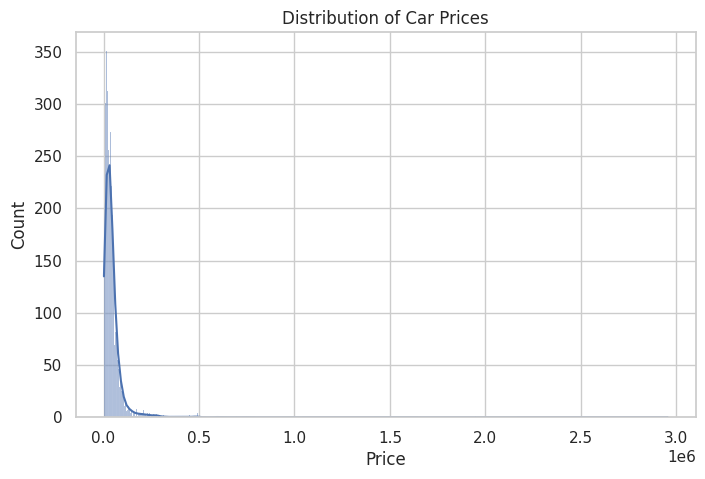

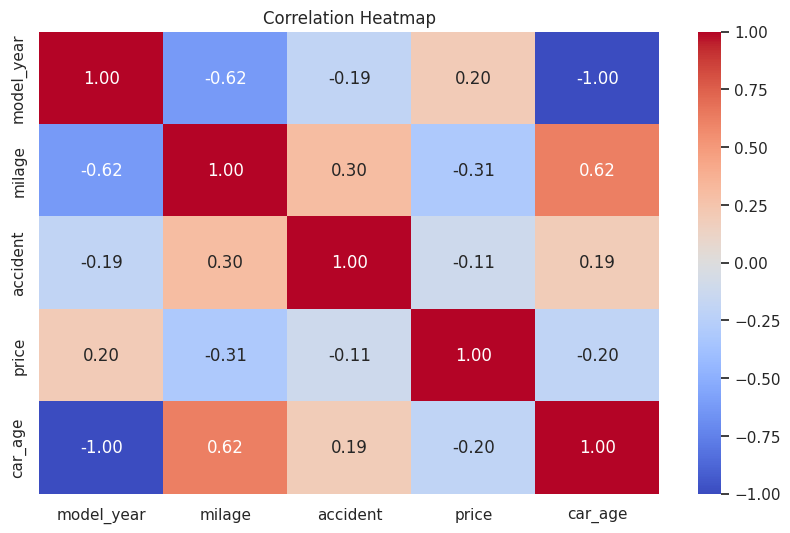

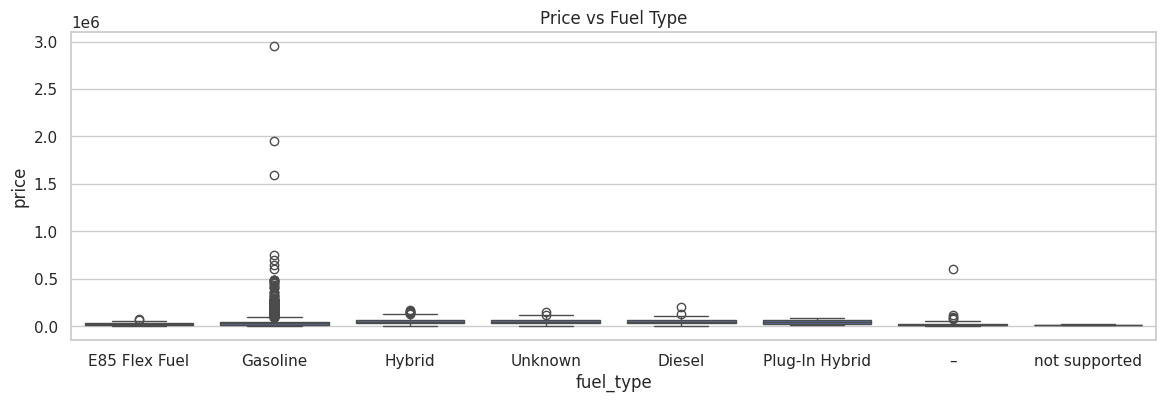

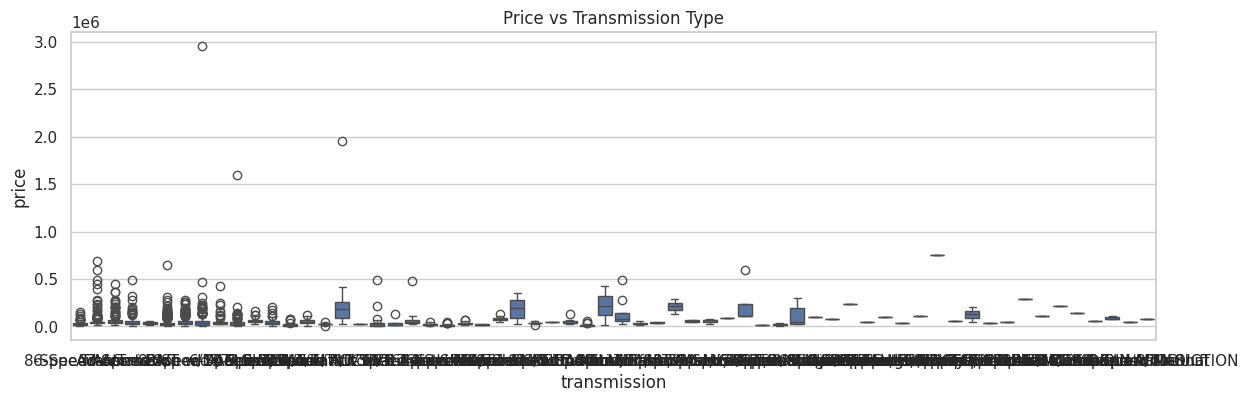

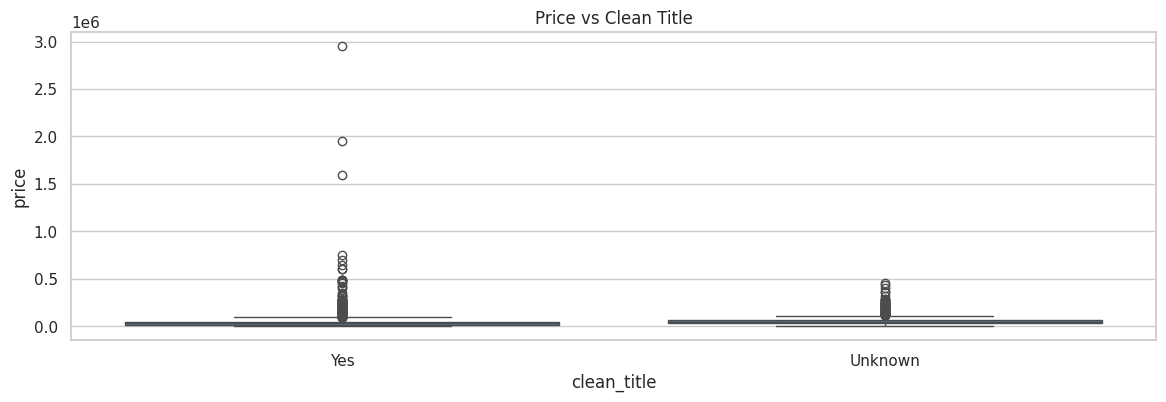

In [6]:
# Visualize target variable
plt.figure(figsize=(8, 5))
sns.histplot(df['price'], kde=True)
plt.title('Distribution of Car Prices')
plt.xlabel('Price')
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Boxplots: Price vs categorical features
plt.figure(figsize=(14, 4))
sns.boxplot(x='fuel_type', y='price', data=df)
plt.title('Price vs Fuel Type')
plt.show()

plt.figure(figsize=(14, 4))
sns.boxplot(x='transmission', y='price', data=df)
plt.title('Price vs Transmission Type')
plt.show()

plt.figure(figsize=(14, 4))
sns.boxplot(x='clean_title', y='price', data=df)
plt.title('Price vs Clean Title')
plt.show()

In [7]:
# Simplify brand: keep Top 10, rest as 'Other'
top_brands = df['brand'].value_counts().nlargest(10).index
df['brand'] = df['brand'].apply(lambda x: x if x in top_brands else 'Other')

# One-hot encode all relevant categorical features
categorical_cols = ['brand', 'fuel_type', 'transmission', 'clean_title']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Preview final dataset
df.head()

,model_year,milage,accident,price,car_age,brand_BMW,brand_Chevrolet,brand_Ford,brand_Jeep,brand_Land,...,transmission_M/T,transmission_Manual,"transmission_Manual, 6-Spd",transmission_SCHEDULED FOR OR IN PRODUCTION,transmission_Single-Speed Fixed Gear,transmission_Transmission Overdrive Switch,transmission_Transmission w/Dual Shift Mode,transmission_Variable,transmission_–,clean_title_Yes
0,2013,51000.00,1,10300.00,12,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
1,2021,34742.00,1,38005.00,4,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,2022,22372.00,0,54598.00,3,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,2015,88900.00,0,15500.00,10,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,2021,9835.00,0,34999.00,4,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [8]:
# Split into X and y
X = df.drop('price', axis=1)
y = df['price']

# Train-test split (80-20)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Train model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict
y_pred_lr = lr.predict(X_test)

# Evaluate
print("🔹 Linear Regression")
print("R² Score:", r2_score(y_test, y_pred_lr))
print("MAE:", mean_absolute_error(y_test, y_pred_lr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))

🔹 Linear Regression
R² Score: 0.06335707600896268
MAE: 28534.096930921783
RMSE: 138363.93891019758


In [10]:
from sklearn.ensemble import RandomForestRegressor

# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred_rf = rf.predict(X_test)

# Evaluate
print("🔹 Random Forest Regressor")
print("R² Score:", r2_score(y_test, y_pred_rf))
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

🔹 Random Forest Regressor
R² Score: 0.10659611252861245
MAE: 25295.26100997506
RMSE: 135132.4987994756


In [12]:
from xgboost import XGBRegressor

# Train XGBoost
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb.predict(X_test)

# Evaluate
print("🔹 XGBoost Regressor")
print("R² Score:", r2_score(y_test, y_pred_xgb))
print("MAE:", mean_absolute_error(y_test, y_pred_xgb))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))

🔹 XGBoost Regressor
R² Score: 0.10385195386528523
MAE: 24489.570584037952
RMSE: 135339.8746037326


<ipython-input-13-9d848691a981>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_df, palette='viridis')


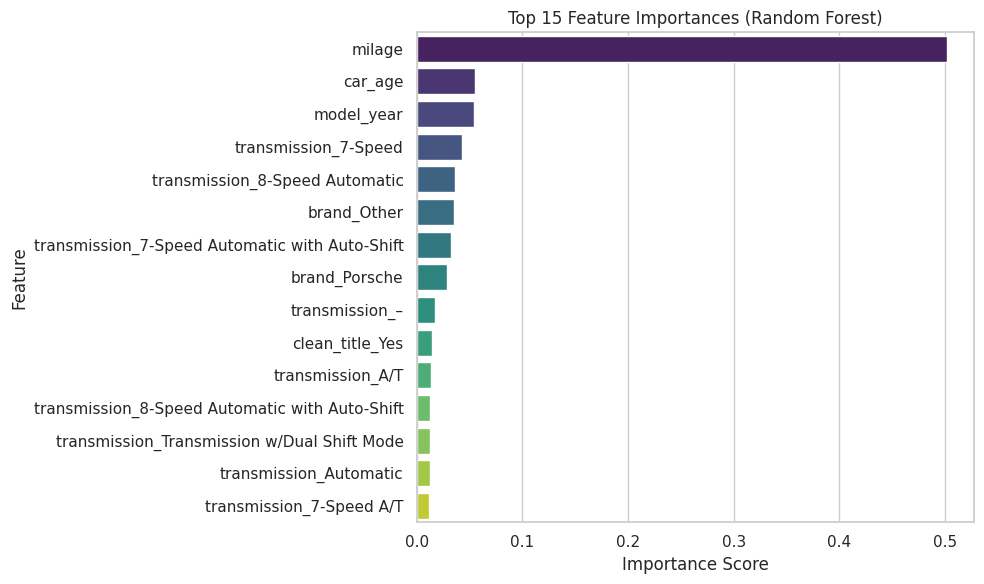

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importances
importances = rf.feature_importances_
features = X.columns
feature_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False).head(15)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_df, palette='viridis')
plt.title('Top 15 Feature Importances (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [15]:
import numpy as np

# Log transform the price column
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

In [16]:
from sklearn.ensemble import RandomForestRegressor

# Train model
rf_log = RandomForestRegressor(n_estimators=100, random_state=42)
rf_log.fit(X_train, y_train_log)

RandomForestRegressor(random_state=42)

In [17]:
# Predict on log scale
y_pred_log = rf_log.predict(X_test)

# Convert back to original price scale
y_pred = np.exp(y_pred_log)

# Evaluate
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

print("🔹 Log-Transformed Random Forest")
print("R² Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

🔹 Log-Transformed Random Forest
R² Score: 0.0875680171568265
MAE: 23766.112194424783
RMSE: 136563.97159951905


In [18]:
import joblib

# Save model
joblib.dump(rf_log, 'rf_model_log.pkl')

# Save feature columns
joblib.dump(X.columns.tolist(), 'model_columns.pkl')

['model_columns.pkl']

In [19]:
import joblib
joblib.dump(rf_log, 'rf_model_log.pkl')

['rf_model_log.pkl']

In [20]:
joblib.dump(X.columns.tolist(), 'model_columns.pkl')

['model_columns.pkl']